In [1]:
import sqlite3 as sql
import csv
import os
from pathlib import Path
from collections import defaultdict

import pandas as pd
from tqdm import tnrange

In [2]:
REPO = (Path(_dh[-1]) / "..").resolve()
DATA = REPO / 'data'

# Map `chembl_targets` to `UniprotID`.

This file is generated with the `kinase-in-chembl` notebooks. Update it if you think there might be more ChEMBL targets.

In [3]:
kinases = pd.read_csv(DATA / "human_kinases_and_chembl_targets.chembl_27.csv")
kinases

,Name,UniprotID,source,chembl_targets,type
0,AAK1,Q2M2I8,kinhub,CHEMBL3830,SINGLE PROTEIN
1,ABL1,P00519,kinhub,CHEMBL1862,SINGLE PROTEIN
2,ABL1,P00519,kinhub,CHEMBL2096618,CHIMERIC PROTEIN
3,ABL1,P00519,kinhub,CHEMBL2111414,PROTEIN FAMILY
4,ABL1,P00519,kinhub,CHEMBL4296119,PROTEIN-PROTEIN INTERACTION
...,...,...,...,...,...
873,PIK3CG,P48736,klifs,CHEMBL3267,SINGLE PROTEIN
874,PIK3CG,P48736,klifs,CHEMBL3430881,PROTEIN COMPLEX
875,PIK3CG,P48736,klifs,CHEMBL4296106,PROTEIN COMPLEX
876,PIK3CG,P48736,klifs,CHEMBL3559703,PROTEIN COMPLEX GROUP


We are only interested in `SINGLE PROTEIN` targets for now.

In [4]:
df = kinases[kinases.type == "SINGLE PROTEIN"].drop("type", axis=1)
df

,Name,UniprotID,source,chembl_targets
0,AAK1,Q2M2I8,kinhub,CHEMBL3830
1,ABL1,P00519,kinhub,CHEMBL1862
9,ABL2,P42684,kinhub,CHEMBL4014
11,TNK2,Q07912,kinhub,CHEMBL4599
12,ACVR2A,P27037,kinhub,CHEMBL5616
...,...,...,...,...
860,PIP5K1C,O60331,klifs,CHEMBL1908383
861,PIK3CA,P42336,klifs,CHEMBL4005
865,PIK3CB,P42338,klifs,CHEMBL3145
869,PIK3CD,O00329,klifs,CHEMBL3130


We will need this dictionary to map between chembl target and uniprot later, when we write the query results to disk.

In [7]:
chembl_to_uniprot = defaultdict(list)
for row in df.to_dict("records"):
    chembl_to_uniprot[row["chembl_targets"]].append(row["UniprotID"])

# Query local ChEMBL DB for speed

Get your local copy from http://doi.org/10.6019/CHEMBL.database.27. You need `chembl_27_sqlite.tar.gz` for this notebook. Extract it and point `DATABASE` below to the `chembl_27.db` file.

In [9]:
DATABASE = "../../_chembl_fetcher/chembl_27/chembl_27_sqlite/chembl_27.db"

In [10]:
conn = sql.connect(DATABASE, isolation_level=None)
db = conn.cursor()

Check which kind of assays can be found on human kinases.

In [11]:
CHEMBL_TARGETS = set(df.chembl_targets.tolist())
q = f"""
SELECT standard_type, COUNT(standard_type) 
FROM activities
    LEFT JOIN assays ON assays.assay_id=activities.assay_id
    LEFT JOIN target_dictionary ON target_dictionary.tid=assays.tid
WHERE
    target_dictionary.chembl_id IN ({', '.join([f'"{x}"' for x in CHEMBL_TARGETS])})
GROUP BY standard_type 
ORDER BY 2 DESC
"""
assay_types = pd.DataFrame.from_records(db.execute(q), columns=["Value", "Count"])
assay_types

,Value,Count
0,IC50,242704
1,Inhibition,238548
2,Ki,136969
3,Residual Activity,70152
4,Kd,52890
...,...,...
121,TC50,1
122,fIC50,1
123,kmax,1
124,kmax/KS,1


In [13]:
assay_types[:10]

,Value,Count
0,IC50,242704
1,Inhibition,238548
2,Ki,136969
3,Residual Activity,70152
4,Kd,52890
5,Kd apparent,52133
6,Potency,50182
7,Activity,35286
8,Thermal melting change,9360
9,EC50,5118


There's a lot of information we are not using! `Inhibition` is as populated as `IC50`, but we don't know what kind of information this category contains.

Get all entries in the SQL db that:

- Correspond to IC50, Ki, Kd measurements. Check `activities.standard_type` fields.
- assay_type = B (Binding)
- Relation = '='
- Target is part of the human kinome (as provided by `/data/human_kinases_and_chembl_targets.chembl_27.csv`)
- Confidence score is greather than zero (in practice, only 43 entries have score=0; the rest are either 8 or 9)

Note that querying for `docs.year` discards ~1000 entries because that field might not be available in those rows and the SELECT query gets dropped.

In [51]:
CHEMBL_TARGETS = set(df.chembl_targets.tolist())
q = f"""
SELECT
    activities.activity_id, target_dictionary.chembl_id, molecule_dictionary.chembl_id, molecule_dictionary.max_phase,
    activities.standard_type, activities.standard_value, activities.standard_units, 
    compound_structures.canonical_smiles, compound_structures.standard_inchi, 
    component_sequences.sequence,
    assays.confidence_score, docs.doc_id, docs.year
FROM 
    activities
    LEFT JOIN assays ON assays.assay_id=activities.assay_id
    LEFT JOIN target_dictionary ON target_dictionary.tid=assays.tid
    LEFT JOIN compound_structures ON activities.molregno=compound_structures.molregno
    LEFT JOIN molecule_dictionary ON activities.molregno=molecule_dictionary.molregno
    LEFT JOIN target_components ON target_dictionary.tid=target_components.tid
    LEFT JOIN component_sequences ON target_components.component_id=component_sequences.component_id
    LEFT JOIN docs ON docs.doc_id=activities.doc_id
WHERE
    target_dictionary.chembl_id IN ({', '.join([f'"{x}"' for x in CHEMBL_TARGETS])})
AND
    activities.standard_relation="="
AND
    assays.assay_type="B"
AND
    activities.standard_type in ("IC50", "Ki", "Kd")
AND
    assays.confidence_score > 0
"""
result = db.execute(q)

In [52]:
with open('activities-chembl27.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["activities.activity_id", "target_dictionary.chembl_id", "molecule_dictionary.chembl_id", "molecule_dictionary.max_phase",
                     "activities.standard_type", "activities.standard_value", "activities.standard_units", 
                     "compound_structures.canonical_smiles", "compound_structures.standard_inchi", 
                     "component_sequences.sequence",
                     "assays.confidence_score", "docs.doc_id", "docs.year", 
                     "UniprotID"])
    for row in result:  # iterate over the query result to avoid loading everything in memory
        writer.writerow(row + ("-".join(chembl_to_uniprot[row[1]]),))

In [53]:
activities = pd.read_csv("activities-chembl27.csv")
activities

,activities.activity_id,target_dictionary.chembl_id,molecule_dictionary.chembl_id,molecule_dictionary.max_phase,activities.standard_type,activities.standard_value,activities.standard_units,compound_structures.canonical_smiles,compound_structures.standard_inchi,component_sequences.sequence,assays.confidence_score,docs.doc_id,docs.year,UniprotID
0,32260,CHEMBL203,CHEMBL68920,0,IC50,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,InChI=1S/C19H15ClFN5O/c1-9-5-10(2)24-15(9)7-12...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,4959,2002.0,P00533
1,32262,CHEMBL279,CHEMBL68920,0,IC50,16500.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,InChI=1S/C19H15ClFN5O/c1-9-5-10(2)24-15(9)7-12...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,8,4959,2002.0,P35968
2,32267,CHEMBL203,CHEMBL69960,0,IC50,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,InChI=1S/C23H20ClFN6O3/c1-12-8-18(23(33)31-4-6...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,4959,2002.0,P00533
3,32330,CHEMBL258,CHEMBL69638,0,IC50,140.0,nM,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,InChI=1S/C23H22N4O/c24-22-21-20(14-27(17-8-4-5...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,9,3891,2000.0,P06239
4,32331,CHEMBL258,CHEMBL69638,0,IC50,1180.0,nM,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,InChI=1S/C23H22N4O/c24-22-21-20(14-27(17-8-4-5...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,9,3891,2000.0,P06239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218096,18813195,CHEMBL4005,CHEMBL4288037,0,Ki,29.0,nM,Nc1cc(C(F)F)c(-c2nc(N3CCOCC3)cc(N3CCOCC3)n2)cn1,InChI=1S/C18H22F2N6O2/c19-17(20)12-9-14(21)22-...,MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,9,110134,2018.0,P42336
218097,18813196,CHEMBL4005,CHEMBL4285727,0,Ki,2190.0,nM,Nc1cc(C(F)(F)F)c(-c2cc(N3C4CCC3COC4)nc(N3C4CCC...,"InChI=1S/C22H25F3N6O2/c23-22(24,25)17-5-19(26)...",MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,9,110134,2018.0,P42336
218098,18813197,CHEMBL4005,CHEMBL4277797,0,Ki,2090.0,nM,Nc1cc(C(F)F)c(-c2cc(N3C4CCC3COC4)nc(N3C4CCC3CO...,InChI=1S/C22H26F2N6O2/c23-21(24)16-5-19(25)26-...,MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,9,110134,2018.0,P42336
218099,18813198,CHEMBL4005,CHEMBL4289122,0,Ki,5668.0,nM,Nc1cc(C(F)(F)F)c(-c2nc(N3C4CCC3COC4)cc(N3C4CCC...,"InChI=1S/C22H25F3N6O2/c23-22(24,25)17-5-18(26)...",MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,9,110134,2018.0,P42336


Distribution of confidence scores:

In [54]:
activities["assays.confidence_score"].value_counts()

9    123422
8     94679
Name: assays.confidence_score, dtype: int64

Distribution of document ids:

59286     9382
102255    5247
48311     2977
52612     2305
102826    1518
94296     1511
103090    1305
94279     1192
94711     1176
52618     1079
Name: docs.doc_id, dtype: int64

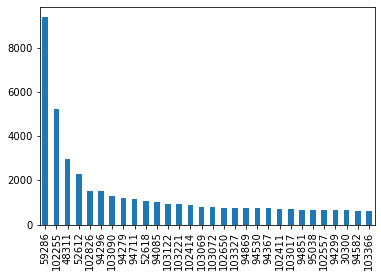

In [55]:
doc_counts = activities["docs.doc_id"].value_counts()
display(doc_counts[:10])
doc_counts[:30].plot.bar();

Distribution of clinical phases:

0    201612
4      6924
2      4060
3      3785
1      1720
Name: molecule_dictionary.max_phase, dtype: int64

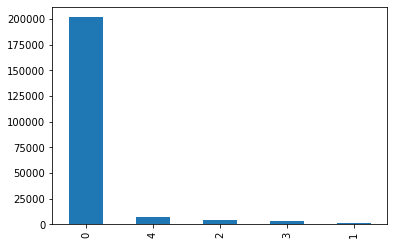

In [56]:
phase_counts = activities["molecule_dictionary.max_phase"].value_counts()
display(phase_counts[:10])
phase_counts[:30].plot.bar();

In [57]:
total_available_measurements = (
      assay_types[assay_types['Value']=='Ki']['Count'].values[0] 
    + assay_types[assay_types['Value']=='IC50']['Count'].values[0] 
    + assay_types[assay_types['Value']=='Kd']['Count'].values[0]
)
print(f'Recovered {(100*(counts[9] + counts[8])/total_available_measurements):.2f}% ({counts[9] + counts[8]} out of {total_available_measurements})')

Recovered 50.42% (218101 out of 432563)
